# Berlin Airbnb Modelling

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
sns.set(style='whitegrid', palette='coolwarm')

Read in the processed data

In [3]:
PROCESSED_PATH = Path("../data/processed/")
listings = pd.read_csv(PROCESSED_PATH/"listings_final.csv")

We have two possible target variables, lets seperate them into different dataframes.

In [4]:
listings_total_price = listings.drop(['price', 'cleaning_fee'], axis=1)
listings = listings.drop('total_price', axis=1)

The plan for this file:

1. Perform feaure selection:

    - Remove highly correlated variables.
    - Remove features with very low correlation with price.
    - Create dummy variables.
    - Create baseline model.
    - Use recursive feature selection/ensemble methods.
    
1. Model with multiple different models.
1. Tune parameters of best model.

We'll start by using the listings with price as the target variable.

## Feature Selection

### Remove Highly Correlated Variables

Firstly, we want to remove variables that are highly correlated with each other. I want to create a function that finds the most highly correlated features and then removes the feature with the lowest correlation with the target.

In [5]:
def drop_correlated_features(dataframe, target, threshold):
    """
    Recursively finds the most highly correlated features over the correlation threshold and then 
    removes the feature with the least correlation with the target variable.
    """
    # Compute feature correlations
    features = dataframe.drop(target, axis=1)
    features_corr = features.corr().abs()
    
    # Take the upper triangle of feature correlations
    features_corr = features_corr.mask(np.tril(np.ones(features_corr.shape, dtype=np.bool_)))
    
    # Find index of correlations greater than the threshold
    correlated_features = zip(*np.where(features_corr > threshold))
    
    # Create dict, correlated features tuple : correlation
    correlated_features = {
        (features_corr.columns[i], features_corr.columns[j]): features_corr.iloc[i,j]
        for i,j in correlated_features
    }
    
    # If no correlations above threshold, return the dataframe
    if not correlated_features:
        return dataframe
    
    # Find most highly correlated features
    max_corr_features = max(correlated_features, key=correlated_features.get)
    
    # Find correlation of features with target
    target_corr = dataframe.corr().abs()[target]
    corrs_with_price = {feature: target_corr[feature] for feature in max_corr_features}
    
    # Drop feature with the least correlation with target
    feature_to_drop = min(corrs_with_price, key=corrs_with_price.get)
    new_dataframe = dataframe.drop(feature_to_drop, axis=1)
    
    return drop_correlated_features(new_dataframe, target, threshold)

Now I can drop features with a absolute pearson correlation greater than 0.9.

In [6]:
listings = drop_correlated_features(listings, 'price', 0.9)

### Remove Features With Low Correlation With Price

I want to remove the features with an absolute pearson correlation lower than 0.05.

In [7]:
target_corr = listings.corr().abs()['price']
low_corr_cols = target_corr.index[np.where(target_corr<0.05)]
listings.drop(low_corr_cols, axis=1, inplace=True)

### Create Dummy Variables

In [8]:
listings = pd.get_dummies(listings, drop_first=True)

### Create Baseline Model

We'll create a linear regression model as the baseline for our models. First, we will create predictors and target variable.

In [9]:
X = listings.drop('price', axis=1)
y = listings['price']

Now we will create a metrics function to give us the metrics we want from each model.

In [10]:
def generate_metrics(model, X_test, y_test):
    """Generate metrics for model."""
    predictions = model.predict(X_test)
    print(f"MSE: {metrics.mean_squared_error(y_test, predictions)}")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, predictions))}")
    print(f"MAE: {metrics.mean_absolute_error(y_test, predictions)}")

In [11]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model and generate metrics
linear_reg = LinearRegression().fit(X_train, y_train)
generate_metrics(linear_reg, X_test, y_test)

MSE: 1013.5874486754145
RMSE: 31.836888175125008
MAE: 19.04101197947567


### Recursive Feature Elimination

We will try recursive feature elimination using linear regression to find an optimal subset of features to train our model using.

In [12]:
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=10, scoring='neg_mean_squared_error')
selector = selector.fit(X_train, y_train)

In [13]:
selector.n_features_

50

In [14]:
RFE_X_train = pd.DataFrame(selector.transform(X_train), columns=X_train.columns[selector.get_support()])
RFE_X_test = pd.DataFrame(selector.transform(X_test), columns=X_test.columns[selector.get_support()])
rfe_lr = LinearRegression().fit(RFE_X_train, y_train)
generate_metrics(rfe_lr, RFE_X_test, y_test)

MSE: 1013.8168670504584
RMSE: 31.840490998890996
MAE: 19.038213738359456


It seems recursive feature elimination hasn't helped in this situation. Lets start training different models using our full data set.

## Modelling

### Lasso

In [15]:
lasso = LassoCV(cv=10).fit(X_train, y_train)
generate_metrics(lasso, X_test, y_test)

MSE: 1100.4896721188134
RMSE: 33.173629167138365
MAE: 19.503705911633762


This offers us no improvement on our base model.

### Nearest Neighbours

First, we must scale our data.

In [16]:
scaler = StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

Now we can train our model on different values of K.

In [17]:
errors = []
for k in range(1,21):
    knn = KNeighborsRegressor(n_neighbors=k).fit(scaled_X_train, y_train)
    predictions = knn.predict(scaled_X_test)
    MSE = metrics.mean_squared_error(y_test, predictions)
    RMSE = np.sqrt(MSE)
    MAE = metrics.mean_absolute_error(y_test, predictions)
    errors.append((MSE, RMSE, MAE))

pd.DataFrame(errors, columns=['MSE', 'RMSE', 'MAE'], index=range(1,21))

,MSE,RMSE,MAE
1,1700.034708,41.231477,24.047464
2,1361.781259,36.902321,21.556586
3,1210.761050,34.795992,20.550331
4,1144.366203,33.828482,19.869957
5,1114.363127,33.382078,19.609641
6,1109.747734,33.312876,19.437605
7,1108.077044,33.287791,19.361444
8,1093.192842,33.063467,19.168885
9,1089.358420,33.005430,19.096444
10,1087.431718,32.976230,19.079027


None of the options for K lower our RMSE enough to be better than our base model.

## Random Forest

In [18]:
rfr = RandomForestRegressor().fit(X_train, y_train)
generate_metrics(rfr, X_test, y_test)

MSE: 889.5558071047166
RMSE: 29.825422161383006
MAE: 17.43308365470187


Text(0.5, 1.0, 'Relative Feature Importances')

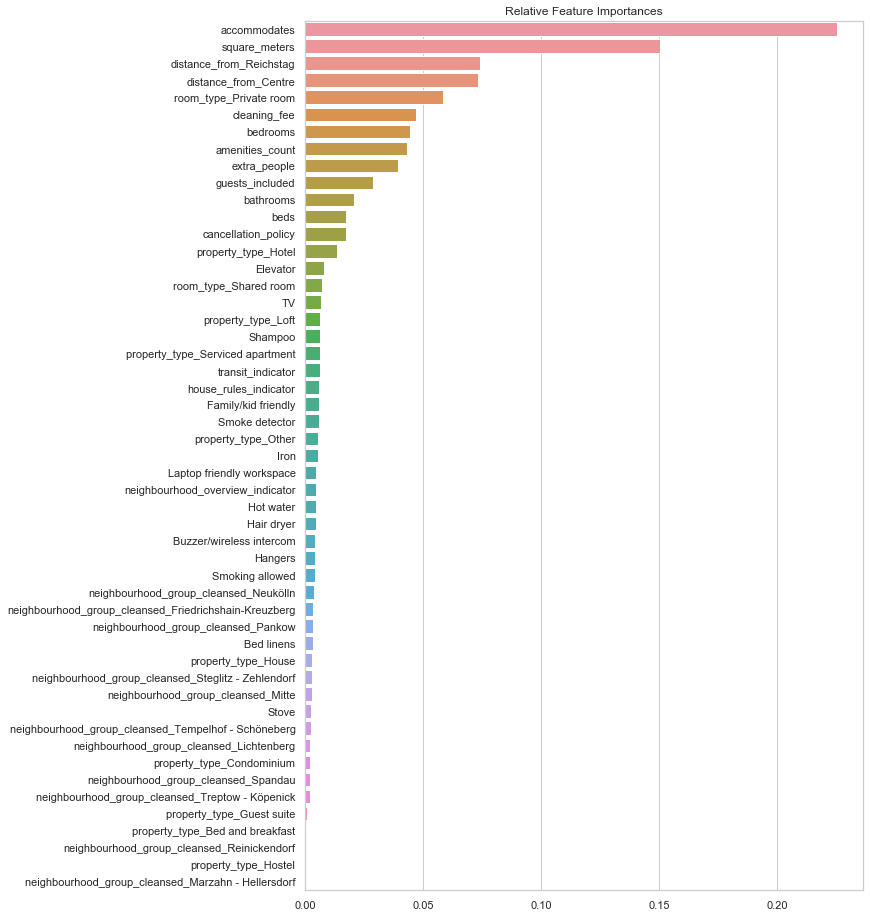

In [19]:
feature_importances = pd.Series(rfr.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,16))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Relative Feature Importances')

In [20]:
sfm = SelectFromModel(rfr, threshold=0.01)
sfm.fit(X_train, y_train);

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                                criterion='mse', max_depth=None,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                max_samples=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=100, n_jobs=None,
                                                oob_score=False,
                                                random_state=None, verbose=0,
                                                war

In [21]:
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [22]:
rfr_important = RandomForestRegressor().fit(X_important_train, y_train)
generate_metrics(rfr_importanttant, X_important_test, y_test)

MSE: 908.354112755859
RMSE: 30.13891359614442
MAE: 17.699578760011864
